# **Trabalho Final - Intelig√™ncia Artificial - Classifica√ß√£o de Pokem√≥ns**

*Equipe:*
- Anna Beatriz - 538758
- Kauan Soares - 537063
- Leonan Marques - 539000
- Victoria Moura - 541801



# **Contextualiza√ß√£o e Conceitos Utilizados**



A proposta principal do nosso trabalho √© criar um modelo de I.A que seja capaz de identificar qual Pokem√≥n aparece em cada imagem dentre um conjunto de imagens. Para isso, utilizamos uma abordagem baseada em Redes Neurais Convolucionais (CNNs), que s√£o amplamente usadas para an√°lise e reconhecimento de imagens.

No entanto, para que a CNN consiga aprender a distinguir cada Pok√©mon corretamente, faremos uso de aprendizado supervisionado. Isso significa que fornecemos ao modelo imagens j√° rotuladas, indicando a qual Pok√©mon cada uma pertence, e o modelo aprende, com base nesses exemplos, a fazer suas pr√≥prias previs√µes.

No nosso projeto, estruturamos a CNN com camadas especializadas:
-  Camadas *Convolucionais*, que identificam padr√µes locais nas imagens, como contornos e cores distintas.
- Camadas de *Pooling*, que reduzem a dimensionalidade da imagem, tornando o modelo mais eficiente.
- Camadas *Densas*, que combinam as informa√ß√µes extra√≠das e fazem a predi√ß√£o final do Pok√©mon.

Essa arquitetura permite que o modelo aprenda progressivamente a reconhecer caracter√≠sticas espec√≠ficas de cada Pok√©mon e utilize essas informa√ß√µes para classific√°-los corretamente.

# **Imports e inicializa√ß√£o**

In [ ]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# **Tratamento dos dados**





O dataset traz um c√≥digo que ja divide as imagens em 80% treino, 10% valida√ß√£o e 10% teste

In [ ]:
# Definir diret√≥rios dos conjuntos de imagens
train_dir = "./pokemon-dataset-1000 - Copia/train"
val_dir = "./pokemon-dataset-1000 - Copia/val"
test_dir = "./pokemon-dataset-1000 - Copia/test"

**`train_dir`**: Conjunto de imagens usado para treinar o modelo.

**`val_dir`**: Conjunto de imagens usado para validar o modelo durante o treinamento.

**`test_dir`**: Conjunto de imagens usado para avaliar o desempenho do modelo ap√≥s o treinamento.

In [ ]:
# Par√¢metros
img_size = (128, 128)
batch_size = 32

**`img_size`** : Define o tamanho de cada imagem que ser√° alimentada ao modelo. Como o modelo de CNN est√° criando est√° lidando com imagens, √© necess√°rio garantir que todas as imagens sejam redimensionadas para um tamanho comum antes de serem passadas para a rede.  

**`batch_size`** : Define o n√∫mero de imagens que ser√£o passadas pela rede neural em uma √∫nica itera√ß√£o durante o treinamento.  

In [ ]:
# Pr√©-processamento das imagens
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

**OBS:** A normaliza√ß√£o ajuda a acelerar o processo de treinamento, pois pode reduzir a variabilidade nos gradientes e melhorar a converg√™ncia. Tamb√©m pode ajudar o modelo a se ajustar de maneira mais eficiente aos dados.

In [ ]:
# Criar os geradores de dados (Treino, Teste e Valida√ß√£o)
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

Found 1028 images belonging to 50 classes.
Found 131 images belonging to 50 classes.
Found 162 images belonging to 50 classes.


**`train_datagen:`** Este √© o objeto de pr√©-processamento que foi configurado anteriormente (com a normaliza√ß√£o dos pixels e, possivelmente, aumentos de dados, caso tenha sido configurado).  

**`flow_from_directory(train_dir):`** Este m√©todo cria um gerador que ir√° buscar as imagens no diret√≥rio train_dir (diret√≥rio que cont√©m as imagens de treinamento). As imagens devem estar organizadas em subpastas, onde cada subpasta representa uma classe. O nome da subpasta ser√° usado como o r√≥tulo da classe.  

**`class_mode="categorical":`** Como estamos tratando um problema de classifica√ß√£o multiclasse, este par√¢metro indica que as labels (r√≥tulos) ser√£o codificadas de forma categ√≥rica. Ou seja, para cada imagem, a sa√≠da ser√° um vetor "one-hot" representando a classe da imagem.

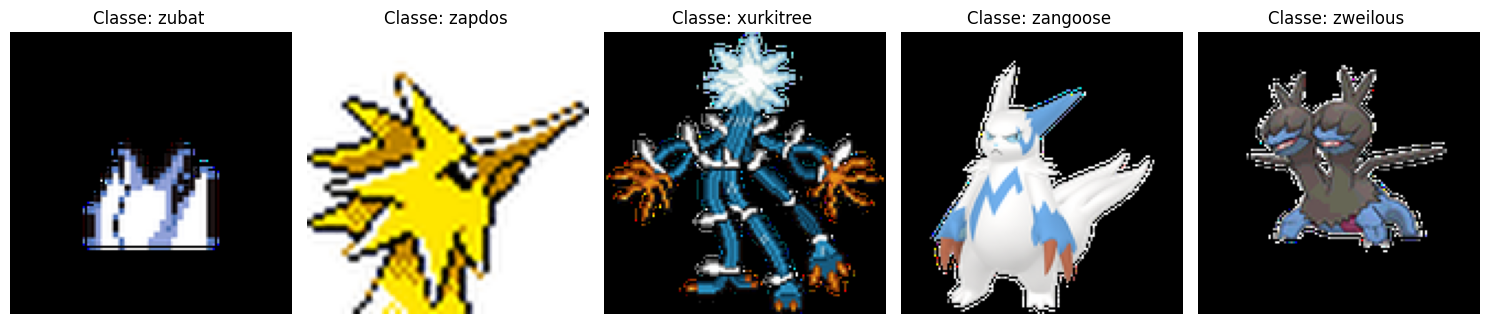

In [ ]:
# Visualizar 5 exemplos do conjunto de treino
class_names = list(train_generator.class_indices.keys())
num_examples = 5

fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
train_images, train_labels = next(train_generator)

for i in range(num_examples):
    img = train_images[i]
    axes[i].imshow(img)
    axes[i].set_title(f"Classe: {class_names[np.argmax(train_labels[i])]} ")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

A classe F1Score herda de tf.keras.metrics.Metric, o que permite criar m√©tricas personalizadas para serem usadas com o TensorFlow/Keras.  
Definimos duas m√©tricas auxiliares: Precision e Recall (essas duas m√©tricas ser√£o usadas para calcular o F1-Score.)  

**OBS**: `Precision` mede a propor√ß√£o de predi√ß√µes positivas corretas, e `recall` mede a propor√ß√£o de inst√¢ncias positivas que foram corretamente identificadas, ou seja, quantas das inst√¢ncias reais positivas foram capturadas pelo modelo.  

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

O pr√≥ximo m√©todo √© chamado durante o treinamento e a avalia√ß√£o do modelo para atualizar o estado da m√©trica.  
Ele recebe os valores verdadeiros (y_true) e preditos (y_pred), e, se necess√°rio, os pesos amostrais (sample_weight). De modo que:

**`self.precision.update_state(y_true, y_pred, sample_weight):`** Atualiza o c√°lculo da precis√£o com base nos valores verdadeiros e preditos.

**`self.recall.update_state(y_true, y_pred, sample_weight):`** Atualiza o c√°lculo do recall com base nos valores verdadeiros e preditos.

In [ ]:
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

Este m√©todo √© chamado para calcular o valor da m√©trica (o F1-Score). Ele retorna o valor final da m√©trica com base nos valores de precis√£o e recall que foram atualizados. (A f√≥rmula √© uma m√©dia harm√¥nica entre a precis√£o e o recall).

In [ ]:
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

O pr√≥ximo m√©todo √© chamado para resetar o estado das m√©tricas de precis√£o e recall. Isso √© necess√°rio entre as √©pocas de treinamento ou quando desejamos limpar as estat√≠sticas internas para um novo c√°lculo.

In [ ]:
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# **Rede Neural Convolucional - CNN**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Explica√ß√£o do problema
# O objetivo deste modelo √© classificar imagens de Pok√©mon utilizando uma Rede Neural Convolucional (CNN).
# O dataset cont√©m m√∫ltiplas classes, cada uma representando um Pok√©mon diferente. O modelo ser√° treinado,
# avaliado e testado para prever corretamente qual Pok√©mon est√° presente em cada imagem.


# Par√¢metros
img_size = (128, 128)
batch_size = 32

# Pr√©-processamento das imagens
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Criar os geradores de dados
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode="categorical"
)

# Definir a m√©trica F1 personalizada
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Criar a CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Exibir arquitetura do modelo
model.summary()

# Compilar o modelo com as m√©tricas de precis√£o, recall e F1Score
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(), F1Score()]
)

# Fun√ß√£o para coletar as m√©tricas durante o treinamento
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)

# Avaliar o modelo no conjunto de teste
loss, accuracy, precision, recall, f1_score_value = model.evaluate(test_generator)
print(f'Loss no teste: {loss:.4f}, Acur√°cia no teste: {accuracy:.4f}, Precis√£o no teste: {precision:.4f}, Recall no teste: {recall:.4f}, F1-Score no teste: {f1_score_value:.4f}')

Found 1028 images belonging to 50 classes.
Found 131 images belonging to 50 classes.
Found 162 images belonging to 50 classes.


/home/kauansoares/UFC/IA/IA/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-25 19:05:57.501100: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d (Conv2D)                 ‚îÇ (None, 126, 126, 32)   ‚îÇ           896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d (MaxPooling2D)    ‚îÇ (None, 63, 63, 32)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_1 (Conv2D)               ‚îÇ (None, 61, 61, 64)     ‚îÇ        18,496 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_1 (MaxPooling2D)  ‚îÇ (None, 30, 30, 64)     ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 28, 28, 128)    ‚îÇ        73,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 14, 14, 128)    ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)               ‚îÇ (None, 25088)          ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 256)            ‚îÇ     6,422,784 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 256)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 50)             ‚îÇ        12,850 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 6,528,882 (24.91 MB)

 Trainable params: 6,528,882 (24.91 MB)

 Non-trainable params: 0 (0.00 B)

/home/kauansoares/UFC/IA/IA/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


2025-02-25 19:06:07.279947: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2025-02-25 19:06:09.153023: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


 1/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6:11 12s/step - accuracy: 0.0625 - f1_score: 0.0000e+00 - loss: 3.9552 - precision: 0.0000e+00 - recall: 0.0000e+00

2025-02-25 19:06:09.990701: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.
2025-02-25 19:06:12.067214: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


 2/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1:36 3s/step - accuracy: 0.0469 - f1_score: 0.0000e+00 - loss: 4.0242 - precision: 0.0000e+00 - recall: 0.0000e+00 

2025-02-25 19:06:13.092015: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 65028096 exceeds 10% of free system memory.


33/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 57s 1s/step - accuracy: 0.0458 - f1_score: 0.0000e+00 - loss: 3.8867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2519 - val_f1_score: 0.0000e+00 - val_loss: 3.4110 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
33/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 36s 1s/step - accuracy: 0.2700 - f1_score: 0.0667 - loss: 2.9990 - precision: 0.4879 - recall: 0.0362 - val_accuracy: 0.5344 - val_f1_score: 0.3145 - val_loss: 2.1188 - val_precision: 0.8929 - val_recall: 0.1908
Epoch 3/5
33/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 35s 1s/step - accuracy: 0.5705 - f1_score: 0.5278 - loss: 1.6446 - precision: 0.8249 - recall: 0.3893 - val_accuracy: 0.8092 - val_f1_score: 0.7143 - val_loss: 1.0369 - val_precision: 0.9494 - val_recall: 0.5725
Epoch 4/5
33/33 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 31s 931ms/step - accuracy: 0.8053 - f1_sco

## üìå Resumo das Camadas Iniciais da CNN

### üéØ Objetivo:
Extrair caracter√≠sticas visuais

---

### üîπ 1. Camada: Convolu√ß√£o 2D
üìå **Fun√ß√£o:**  
Detecta caracter√≠sticas espaciais nas imagens, detectando padr√µes locais.

‚úÖ **Par√¢metros:**  
| *ParaÃÇmetro*      | *DescricÃßaÃÉo* |
|--------------------|--------------|
| filters=32      | Define *32 filtros (ou kernels)* para detectar padroÃÉes na imagem (bordas, texturas, etc.). Cada filtro aprende uma caracteriÃÅstica diferente. |
| kernel_size=(3,3) | O tamanho do *filtro deslizante* eÃÅ *3x3 pixels*. Isso significa que ele analisa pequenos blocos da imagem por vez. |
| activation='relu' | Usa a funcÃßaÃÉo de ativacÃßaÃÉo *ReLU (Rectified Linear Unit)* para remover valores negativos e manter apenas os positivos. |
| input_shape=(128, 128, 3) | Especifica o formato das imagens de entrada: *128x128 pixels, com 3 canais de cor (RGB)*. |

**üéØ Sa√≠da:**
Matriz com 32 canais contendo as "versoÃÉes filtradas" da imagem.

```python
Conv2D()
```

### üîπ 2. Camada: MaxPooling

üìå **Fun√ß√£o:**
Redu√ß√£o das dimens√µes da imagem, reduzindo c√°lculos e melhorando a efici√™ncia, mantendo apenas os pontos importantes.
Evita overfitting, pela redu√ß√£o da complexidade do modelo

```python
MaxPooling2D(pool_size=(2,2))
```

### üîπ 3. Camada: Segunda ConvolucÃßaÃÉo

üìå **Fun√ß√£o:**
Como a imagem jaÃÅ foi reduzida antes pelo MaxPooling, agora os *filtros podem aprender padroÃÉes mais abstratos, como **formas completas (olhos, cauda, etc.)*.

‚úÖ **Par√¢metros**
| *ParaÃÇmetro*      | *DescricÃßaÃÉo* |
|--------------------|--------------|
| filters=64      | Agora a camada tem *64 filtros* para aprender *padroÃÉes mais complexos* (ex.: contornos e formatos). |
| kernel_size=(3,3) | Continua analisando pedacÃßos de *3x3 pixels* da imagem. |
| activation='relu' | A funcÃßaÃÉo ReLU manteÃÅm apenas valores positivos. |


```python
Conv2D(filters=64, kernel_size=(3,3), activation='relu')
```

### üîπ 4. Camada: MaxPooling

üìå **Fun√ß√£o:**
Como na sua utiliza√ß√£o anterior, ir√° reduzir o tamanho da imagem pela metade

```python
MaxPooling2D(pool_size=(2,2))
```

### üîπ 5. Camada: Terceira ConvolucÃßaÃÉo

üìå **Fun√ß√£o:**
Permitir√° a rede reconhecer combina√ß√µes de formas, no escopo do projeto, ela reconhecer√° um pok√©mon inteiro, e n√£o apenas seus contornos
Quando mais camadas convolucionais, mas poder de abstra√ß√£o o modelo ter√°

‚úÖ **Par√¢metros**
| *ParaÃÇmetro*      | *DescricÃßaÃÉo* |
|--------------------|--------------|
| filters=128      | Agora temos *128 filtros, pois estamos aprendendo padroÃÉes **ainda mais complexos*. |
| kernel_size=(3,3) | Mantemos um filtro pequeno para capturar detalhes. |
| activation='relu' | Continua removendo valores negativos. |

### üîπ 6. Camada: MaxPooling

üìå **Fun√ß√£o:**
Reduz novamente o tamanho da imagem.
Agora a rede foca apenas nas *informacÃßoÃÉes mais importantes*.

```python
MaxPooling2D(pool_size=(2,2))
```

## üìå Resumo Geral das Camadas Iniciais
- Camada Convolucional extrai pequenos padroÃÉes da imagem.  
- MaxPooling reduz a dimensaÃÉo e manteÃÅm apenas os pontos mais importantes.  
- Camada Convolucional aprende padroÃÉes mais abstratos.  
- MaxPooling reduz mais a dimensaÃÉo.  
- Camada Convolucional aprende formas completas.  
- MaxPooling manteÃÅm apenas as informacÃßoÃÉes mais relevantes.  


## üìå Resumo das Camadas Finais da CNN (A partir de Flatten)

### üéØ Objetivo:
Ap√≥s extrair caracter√≠sticas visuais, as camadas finais **combinam essas informa√ß√µes para realizar a classifica√ß√£o**.

---

### üîπ 1. Camada **Flatten (Achatamento)**
üìå **Fun√ß√£o:**  
Transforma os mapas de caracter√≠sticas (matrizes 2D) em um **vetor 1D** para ser processado pelas camadas densas.

‚úÖ **Entrada:**  
Matriz de caracter√≠sticas extra√≠das pelas camadas convolucionais (ex.: `8x8x128`).

üéØ **Sa√≠da:**  
Vetor linear (`8192`, se `8*8*128`).

```python
Flatten()
```

### üîπ 2. Camada Densa (256 Neur√¥nios, ReLU)

üìå **Fun√ß√£o:**
Combina as caracter√≠sticas extra√≠das para reconhecer padr√µes abstratos e tomar decis√µes.

‚úÖ **Par√¢metros**

    Dense(256, activation='relu')
    256 neur√¥nios aprendem padr√µes combinados.
    ReLU impede valores negativos e melhora o treinamento.

üí° **O que acontece aqui?**

    "Se h√° bordas pontiagudas e tom laranja predominante, √© Charmander."
    "Se h√° orelhas arredondadas e tom amarelo, √© Pikachu."

```python
Dense(256, activation='relu')
```

### üîπ 3. Camada Dropout (50%)

üìå **Fun√ß√£o:**
Reduz overfitting desativando aleatoriamente 50% dos neur√¥nios dessa camada a cada itera√ß√£o.

‚úÖ **Par√¢metros**

    Dropout(0.5)

üéØ **Benef√≠cio:**

    ‚ùå Evita que o modelo fique muito dependente de neur√¥nios espec√≠ficos.
    ‚úÖ Melhora generaliza√ß√£o para novas imagens.

```python
Dropout(0.5)
```

### üîπ 4. Camada Densa Final (Sa√≠da, Softmax)

üìå **Fun√ß√£o:**
Gera as probabilidades para cada classe de Pok√©mon.

‚úÖ **Par√¢metros**

    Dense(num_classes, activation='softmax')
    N√∫mero de neur√¥nios = n√∫mero de classes (ex.: 4 para Pikachu, Charmander, Bulbasaur e Squirtle).
    Softmax converte valores em probabilidades.

üéØ **Exemplo de sa√≠da:**

[Pikachu: 0.80, Charmander: 0.15, Bulbasaur: 0.03, Squirtle: 0.02]

‚û° Resposta final: Pikachu! ‚úÖ

```python
Dense(num_classes, activation='softmax')
```

## üìå Resumo Geral das Camadas
- Camada	Fun√ß√£o Principal	Detalhes
- Flatten	Transforma mapas de caracter√≠sticas em um vetor 1D.	Entrada: matriz ‚Üí Sa√≠da: vetor
- Dense (256, ReLU)	Aprende rela√ß√µes complexas entre padr√µes extra√≠dos.	256 neur√¥nios totalmente conectados.
- Dropout (50%)	Previne overfitting desativando neur√¥nios aleatoriamente.	Evita que o modelo memorize o conjunto de treino.
- Dense (Softmax)	Gera as probabilidades de cada classe.	N√∫mero de neur√¥nios = n√∫mero de classes.

# **Visualiza√ß√£o**

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 201ms/step


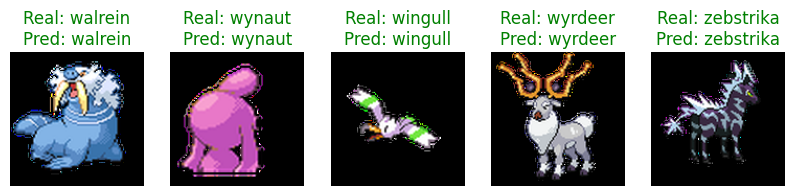

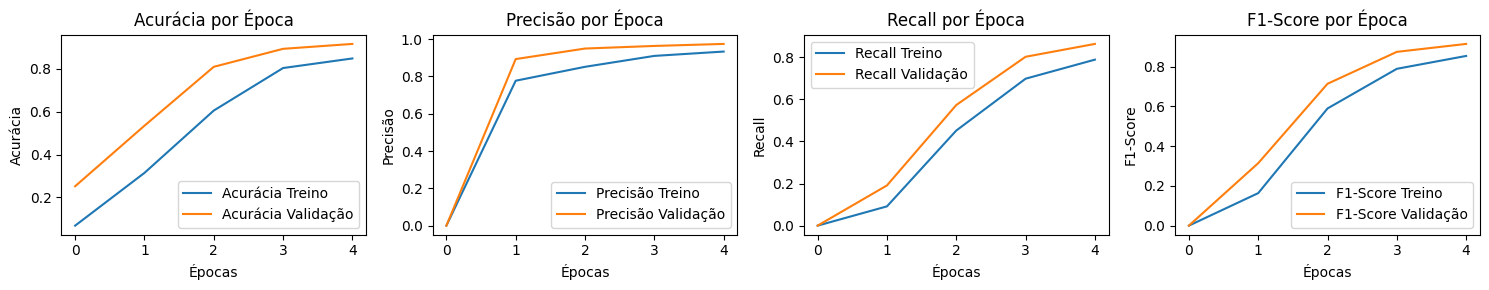

In [ ]:
# Mostrar algumas imagens de teste com r√≥tulos reais e preditos
class_names = list(train_generator.class_indices.keys())
images, labels = next(test_generator)
predictions = model.predict(images)
pred_labels = np.argmax(predictions, axis=1)

num_images = min(len(images), 5)

fig, axes = plt.subplots(1, num_images, figsize=(10, 3))
for i in range(num_images):
    axes[i].imshow(images[i])
    true_label = class_names[np.argmax(labels[i])]
    predicted_label = class_names[pred_labels[i]]
    color = "green" if true_label == predicted_label else "red"
    axes[i].set_title(f"Real: {true_label}\nPred: {predicted_label}", color=color)
    axes[i].axis("off")
plt.show()

# Plotar as curvas das m√©tricas
plt.figure(figsize=(15, 3))

# Acur√°cia
plt.subplot(1, 4, 1)
plt.plot(history.history['accuracy'], label='Acur√°cia Treino')
plt.plot(history.history['val_accuracy'], label='Acur√°cia Valida√ß√£o')
plt.xlabel('√âpocas')
plt.ylabel('Acur√°cia')
plt.legend()
plt.title('Acur√°cia por √âpoca')

# Precis√£o
plt.subplot(1, 4, 2)
plt.plot(history.history['precision'], label='Precis√£o Treino')
plt.plot(history.history['val_precision'], label='Precis√£o Valida√ß√£o')
plt.xlabel('√âpocas')
plt.ylabel('Precis√£o')
plt.legend()
plt.title('Precis√£o por √âpoca')

# Recall
plt.subplot(1, 4, 3)
plt.plot(history.history['recall'], label='Recall Treino')
plt.plot(history.history['val_recall'], label='Recall Valida√ß√£o')
plt.xlabel('√âpocas')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall por √âpoca')

# F1-Score
plt.subplot(1, 4, 4)
plt.plot(history.history['f1_score'], label='F1-Score Treino')
plt.plot(history.history['val_f1_score'], label='F1-Score Valida√ß√£o')
plt.xlabel('√âpocas')
plt.ylabel('F1-Score')
plt.legend()
plt.title('F1-Score por √âpoca')

plt.tight_layout()
plt.show()

No contexto do treinamento de modelos de machine learning, especialmente em classificacÃßaÃÉo, acuraÃÅcia e precisaÃÉo saÃÉo meÃÅtricas diferentes que avaliam diferentes aspectos do desempenho do modelo.

AcuraÃÅcia: ProporcÃßaÃÉo de previsoÃÉes corretas (tanto verdadeiros positivos quanto verdadeiros negativos) em relacÃßaÃÉo ao total de previsoÃÉes feitas. √â uma meÃÅtrica geral que indica a porcentagem de previsoÃÉes corretas feitas pelo modelo.

        AcuraÃÅcia = (Verdadeiros positivos + Verdadeiros negativos) / Total de previsoÃÉes


PrecisaÃÉo: A proporcÃßaÃÉo de verdadeiros positivos em relacÃßaÃÉo ao total de previsoÃÉes positivas feitas pelo modelo. Mede a exatidaÃÉo das previsoÃÉes positivas do modelo. EÃÅ particularmente uÃÅtil quando o custo de falsos positivos eÃÅ alto.

        PrecisaÃÉo = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos)


Recall: √â a propor√ß√£o de verdadeiros positivos em rela√ß√£o ao total de positivos reais (verdadeiros positivos + falsos negativos). Mede a capacidade do modelo de identificar corretamente todas as inst√¢ncias positivas.

        Recall = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos)

F1-Score: √â a m√©dia harm√¥nica da precis√£o e do recall. O F1-score √© uma m√©trica √∫til quando se precisa equilibrar precis√£o e recall, especialmente em situa√ß√µes onde h√° uma distribui√ß√£o desigual das classes.

        F1-Score = 2 x (Precis√£o x Recall) / (Precis√£o + Recall)


Isso permite uma avaliacÃßaÃÉo completa do desempenho do modelo, considerando diferentes aspectos importantes para a tarefa de¬†classificacÃßaÃÉo.
